## Expedia Bookings ##

We had trouble reading in the data on our local machines in Python or R, so we used SAS. SAS stores data on the local disk, so we aren't limited by our RAM.

** I imagine most of us (including our group) are ignorant of how to analyze data when we can't get data into our memory. This is where you have to parralelize computations, and optimizing objective functions needs to be done in more clever ways (i.e. Stochastic Gradient Descent) **

We found out that the training set contained both observations in which people booked hotels and did not book hotels (i.e. they just searched). But, the test set only contains observations in which people booked hotels. Therefore, we made the decision to subset only on booking customers. This may not be optimal, since its possible that people who searched for hotels still have information on the cluster, but I we would argue its reasonable.

### Evaluation Criterion 
* "Mean Average Prediction"
    
    $\text{MAP@5} = \frac{1}{|U|} \sum_{u=1}^{|U|}\sum_{k=1}^{min(5,n)} P(k)$
where u is a user and P(k) is the precision at cutoff k.

There isn't a ton of details out there, but the idea is that a customer books a hotel, and we give him a top five recommendations based on thier features. Thus, we return $\bf{\widehat{p}} = \left[\widehat{p}_{1} \dots \widehat{p}_{5}\right]$ where $\widehat{p}_{1}$ is the (estimated) most probable choice, and so on. The idea is we are doing better (less loss) when we have the option they actually choose earlier in our list 

In [8]:
import pandas as pd
import scipy.stats
import numpy as np

In [9]:
## Reading in book data. Let me know if you need me to send you only the booking data ##
hotel = pd.read_csv("book.csv",header = 0)

In [10]:
hotel.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,11AUG14:08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
1,27FEB14:18:01:32,2,3,66,318,52078,NaN,756,0,1,...,0,1,8291,1,1,1,2,50,191,2
2,15JUN13:15:38:05,30,4,195,548,56440,NaN,1048,0,1,...,0,1,1385,1,1,1,0,185,185,58
3,23NOV14:18:02:20,30,4,195,991,47725,NaN,1048,0,0,...,0,1,8803,1,1,1,3,151,69,36
4,03JAN14:16:30:17,2,3,66,462,41898,2454.8588,1482,0,1,...,0,2,12009,1,1,1,2,50,680,95


In [11]:
hotel.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

### Features
* **Response** - We want to predict what hotel clustering. There are 100 clusters. We are not given much info on what these clusters are. We can guess that they took features of the hotels, and ran some sort of clustering method. 

* We are given information on when they booked, which site they used, and information on where the user is located. We also have the distance  between the hotel and a customer at the time of the search. 

* It is also possible that a user could have multiple observations on the same user. But, I think we should treat the observations as indepedent here. 

* Also have information on the number of hotel rooms specified in the search, the number of adults/children, and the hotel location. 

* There is an enigmatic feature called srch_destination_type. On the kaggle site, there is a file called destinations.csv. The description in this file is "hotel search latent attributes". This file has 148 numbers associated with each destinaton type. What these numbers are, nobody knows!

It may be reasonable to employ PCA (or some sort of unsupervised learning) on this file, and then add in the derived features as predictors.  

In [4]:
pd.crosstab(index=hotel["hotel_cluster"],columns="count")

col_0,count
hotel_cluster,
0,19227
1,38450
2,45055
3,12413
4,35589
5,42734
6,44449
7,34726
8,22313


In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

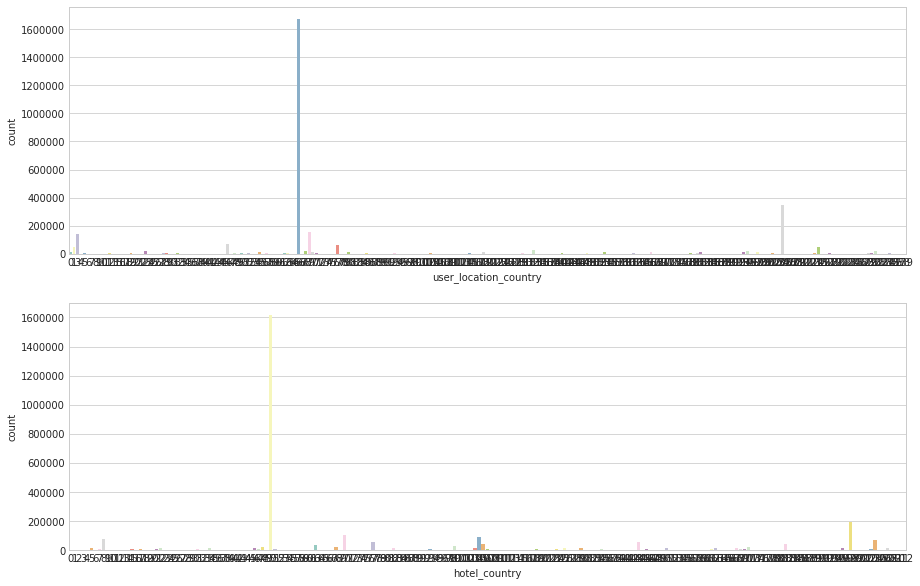

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline



fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))



# What are the most countries the customer travel from?
sns.countplot('user_location_country',data=hotel.sort_values(by=['user_location_country']),ax=axis1,palette="Set3")

# What are the most countries the customer travel to?
sns.countplot('hotel_country',data=hotel.sort_values(by=['hotel_country']),ax=axis2,palette="Set3")

In [5]:
pd.crosstab(index=hotel["hotel_cluster"],columns="count").min(0)

col_0
count    2465
dtype: int64

In [12]:
def chi2(x):
    z=np.array([[hotel["hotel_cluster"]],[hotel[x]]])
    return(scipy.stats.chi2_contingency(z))


In [13]:
chi2("site_name")

(45363527.972681776,
 0.0,
 3000692,
 array([[[  2.50723213,   3.34297618,  73.54547585, ...,  58.50208306,
           66.02377946,  36.77273793]],
 
        [[  0.49276787,   0.65702382,  14.45452415, ...,  11.49791694,
           12.97622054,   7.22726207]]]))

In [14]:
chi2("srch_destination_type_id")

(14880193.503475934,
 0.0,
 3000692,
 array([[[  1.88615696,   2.82923544,  55.64163032, ...,  65.07241512,
           73.56012144,  40.55237464]],
 
        [[  0.11384304,   0.17076456,   3.35836968, ...,   3.92758488,
            4.43987856,   2.44762536]]]))

### If we look at some chi-square tests, there happens to be sparseness; i.e. zero cells. Thus traditional methods like chi-square, and logistic regression are infeasible. 

In [15]:
chi2("posa_continent")

ValueError: The internally computed table of expected frequencies has a zero element at (0, 0, 15943).

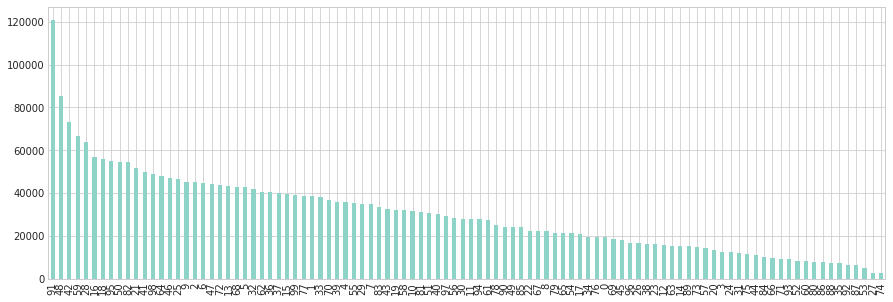

In [14]:
hotel["hotel_cluster"].value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

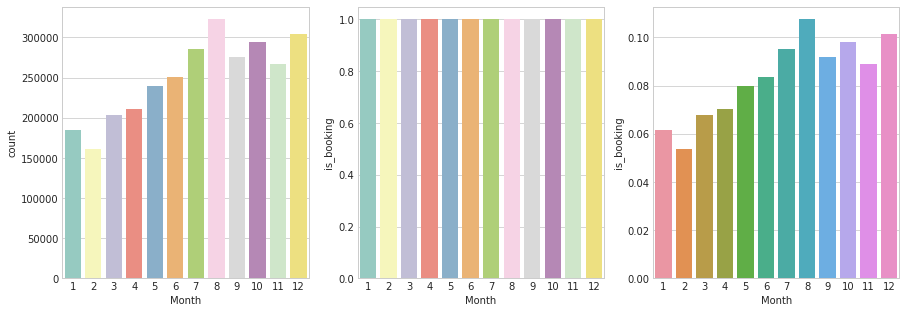

In [23]:
hotel['Year']   = hotel['srch_ci'].apply(lambda x: int(str(x)[:4]) if x == x else np.nan)
hotel['Month']  = hotel['srch_ci'].apply(lambda x: int(str(x)[5:7]) if x == x else np.nan)
hotel['Week']   = hotel['srch_ci'].apply(lambda x: int(str(x)[8:10]) if x == x else np.nan)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,sharex=True,figsize=(15,5))

# Plot How many bookings in each month
sns.countplot('Month',data=hotel,order=list(range(1,13)),palette="Set3",ax=axis1)

# Plot The percentage of bookings of each month(sum of month bookings / count of bookings(=1 OR =0) of a month)
# sns.factorplot('Month',"is_booking",data=expedia_df, order=list(range(1,13)), palette="Set3",ax=axis2)
sns.barplot('Month',"is_booking",data=hotel, order=list(range(1,13)), palette="Set3",ax=axis2)

# Plot The percentage of bookings of each month compared to all bookings(sum of month bookings / count of bookings(=1) of all months)
month_sum = hotel[['Month', 'is_booking']].groupby(['Month'],as_index=False).sum()
month_sum['is_booking'] = month_sum['is_booking'] / len(hotel[hotel['is_booking'] == 1])

sns.barplot(x='Month', y='is_booking', order=list(range(1,13)), data=month_sum,ax=axis3) 

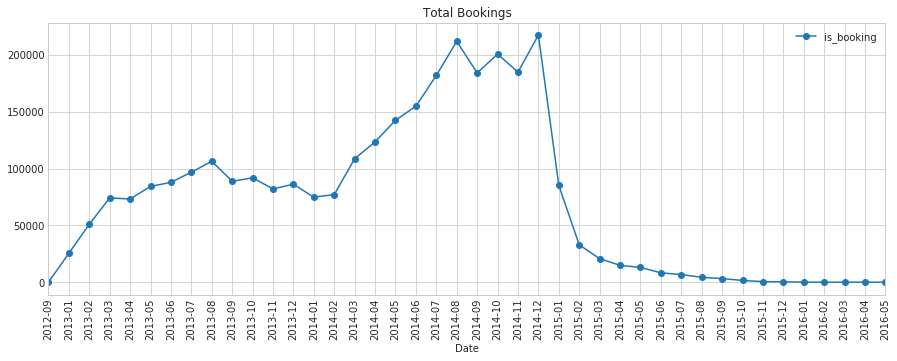

In [24]:
# Convert srch_ci column to Date(Y-M)
hotel['Date']  = hotel['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)

# Plot number of bookings over Date
date_bookings  = hotel.groupby('Date')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)